Notebook on difference-in-difference estimation with repeated cross section data.

 - Repeated cross-section over 6 periods, from period 0 to period 5
 - Variable of interest `var1`
 - Two separate groups in data: `treatment` and `control`
 - A one-off treatment between periods 2 and 3 (i.e. no staggered treatment) affecting `var1` for observations in `treatment` only
 - Time-invariant but T/C group variant effect `GC`
 - Time-and-group variant effect `TGC`
 - Random time-variant effect `e_t` (affecting `treatment` and `control` in similar manner)

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(dagitty)

## DAG of data generating process

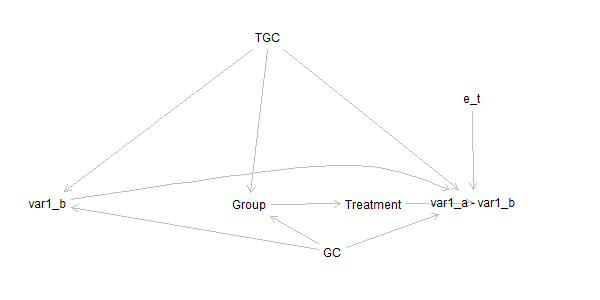

In [3]:
%%R -h 300 -w 600
g = dagitty('
    dag {
    " " [pos="-1.852,-1.353"]
    "" [pos="0.925,1.366"]
    "var1_a - var1_b" [outcome,pos="0.429,0.559"]
    GC [adjusted,pos="-0.312,1.086"]
    Group [pos="-0.746,0.581"]
    TGC [adjusted,pos="-0.646,-1.190"]
    Treatment [exposure,pos="-0.095,0.574"]
    e_t [pos="0.424,-0.534"]
    var1_b [pos="-1.801,0.570"]
    GC -> "var1_a - var1_b"
    GC -> Group
    GC -> var1_b
    Group -> Treatment
    TGC -> "var1_a - var1_b"
    TGC -> Group
    TGC -> var1_b
    Treatment -> "var1_a - var1_b" [pos="0.314,0.581"]
    e_t -> "var1_a - var1_b"
    var1_b -> "var1_a - var1_b" [pos="-0.089,0.016"]
    }
')
plot(g)

## Simulate data

In [4]:
def simulate_data(treatment_size, tgc_mean_c, gc_mean_c, gc_mean_t):
    
    for t in range(6):

        common_random_trend_deviation = np.abs(np.random.random())

        # Control group
        df_t = pd.DataFrame(np.random.random(size=300), columns=["var1"]) + t * common_random_trend_deviation

        # Group confounding for control
        df_t["GC"] = np.random.normal(loc=gc_mean_c, scale=1.0, size=300)
        df_t["var1"] = df_t["var1"] + df_t["GC"]

        # Time confounding for control
        if t >= 2:
            df_t["TGC"] = np.random.normal(loc=tgc_mean_c, scale=1.0, size=300)
            df_t["var1"] = df_t["var1"] + df_t["TGC"]
        else:
            df_t["TGC"] = np.random.normal(loc=0, scale=1.0, size=300)
            df_t["var1"] = df_t["var1"] + df_t["TGC"]

        df_t["t"] = t
        if t == 0:
            control = df_t
        else:
            control = control.append(df_t, ignore_index=True)

        # Treatment group
        df_t = pd.DataFrame(np.random.random(size=300), columns=["var1"]) + t * common_random_trend_deviation

        # Group confounding for treatment
        df_t["group_confounding"] = np.random.normal(loc=gc_mean_t, scale=1.0, size=300)
        df_t["var1"] = df_t["var1"] + df_t["group_confounding"]

        # Time confounding for treatment
        df_t["TGC"] = np.random.normal(loc=0, scale=1.0, size=300)
        df_t["var1"] = df_t["var1"] + df_t["TGC"]

        df_t["t"] = t
        if t == 0:
            treatment_cf = df_t
        else:
            treatment_cf = treatment_cf.append(df_t, ignore_index=True)

    treatment_cf["time_group"] = np.where(treatment_cf["t"] > 2, "after", "before")
    control["time_group"] = np.where(control["t"] > 2, "after", "before")
    treatment_cf["tc_group"] = "treatment"
    control["tc_group"] = "control"

    treatment = treatment_cf.copy()
    treatment.loc[treatment["time_group"] == "after", "var1"] = treatment.loc[treatment["time_group"] == "after", "var1"] + treatment_size

    # Save mean values
    means = {}
    means["control_before"] = control.query("time_group == 'before'")["var1"].mean()
    means["control_after"] = control.query("time_group == 'after'")["var1"].mean()
    means["treatment_before"] = treatment.query("time_group == 'before'")["var1"].mean()
    means["treatment_after"] = treatment.query("time_group == 'after'")["var1"].mean()
    means["treatment_cf_before"] = treatment_cf.query("time_group == 'before'")["var1"].mean()
    means["treatment_cf_after"] = treatment_cf.query("time_group == 'after'")["var1"].mean()
    for t in range(6):
        means["control_t" + str(t)] = control.query("t == {}".format(t))["var1"].mean()
        means["treatment_t" + str(t)] = treatment.query("t == {}".format(t))["var1"].mean()
        means["treatment_cf_t" + str(t)] = treatment_cf.query("t == {}".format(t))["var1"].mean()
        
    return {"treatment": treatment, "control": control, "treatment_cf": treatment_cf, "means": means}

# Data with no TGC effect
data_1 = simulate_data(
    treatment_size = -2,
    tgc_mean_c = 0,
    gc_mean_c = -1,
    gc_mean_t = 1.5,
)

# Data with TGC effect
data_2 = simulate_data(
    treatment_size = -2,
    tgc_mean_c = 1,
    gc_mean_c = -1,
    gc_mean_t = 1.5,
)

## Plot data

In [5]:
def plot_data(data):
    
    treatment = data["treatment"]
    control = data["control"]
    treatment_cf = data["treatment_cf"]
    means = data["means"]
    
    time_fe_mean_line_pos = [(0, 0.1), (0.175, 0.275), (0.375, 0.475), (0.55, 0.65), (0.75, 0.825), (0.90, 1)]
    def format_ax(ax):
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.axvline(2.5, linestyle="--", c="red")
        ax.set_ylim(-4, 8)
        
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(2, 1, 1)
    control.plot.scatter(x="t", y="var1", ax=ax, s=1)
    ax.axhline(y=means["control_before"], xmin=0, xmax=0.5, linestyle="--")
    ax.axhline(y=means["control_after"], xmin=0.5, xmax=1.0, linestyle="--")
    for t, xminmax in zip(range(6), time_fe_mean_line_pos):
        ax.axhline(y=means["control_t" + str(t)], xmin=xminmax[0], xmax=xminmax[1], linestyle="--")

    format_ax(ax)
    ax.set_title("Control")

    ax = fig.add_subplot(2, 1, 2)
    treatment.plot.scatter(x="t", y="var1", ax=ax, s=1)
    treatment_cf.query("time_group == 'after'").plot.scatter(x="t", y="var1", ax=ax, color="orange", s=1)
    ax.axhline(y=means["treatment_before"], xmin=0, xmax=0.5, linestyle="--")
    ax.axhline(y=means["treatment_cf_after"], xmin=0.5, xmax=1.0, linestyle="--", color="orange")
    ax.axhline(y=means["treatment_after"], xmin=0.5, xmax=1.0, linestyle="--")
    ax.axhline(y=means["treatment_before"] + (means["control_after"] - means["control_before"]), xmin=0.5, xmax=1.0, linestyle="--", color="green")
    for t, xminmax in zip(range(6), time_fe_mean_line_pos):
        ax.axhline(y=means["treatment_t" + str(t)], xmin=xminmax[0], xmax=xminmax[1], linestyle="--")
        if t > 2:
            ax.axhline(y=means["treatment_cf_t" + str(t)], xmin=xminmax[0], xmax=xminmax[1], linestyle="--", color="orange")
    format_ax(ax)
    ax.set_title("Treatment")

    fig.tight_layout()

    print("Control before mean {:.3f}".format(means["control_before"]))
    print("Control after mean {:.3f}".format(means["control_after"]))
    print("Treament before mean {:.3f}".format(means["treatment_before"]))
    print("Treament after mean {:.3f}".format(means["treatment_after"]))
    print("Treatment counterfactual after mean {:.3f}".format(means["treatment_cf_after"]))

    for el in ["control", "treatment", "treatment_cf"]:
        for t in range(6):
            print("{} t_{} mean {:.3f}".format(
                el,
                t, 
                means[el + "_t" + str(t)],
            ))
    print("Treatment estimated counterfactual after mean {:.3f}".format(means["treatment_before"] + (means["control_after"] - means["control_before"])))
    print("Simple did-estimate {:.3f}".format(
        (means["treatment_after"] - means["treatment_before"]) -     
        (means["control_after"] - means["control_before"])
    ))

Control before mean 0.252
Control after mean 2.847
Treament before mean 2.886
Treament after mean 3.482
Treatment counterfactual after mean 5.482
control t_0 mean -0.479
control t_1 mean 0.149
control t_2 mean 1.086
control t_3 mean 2.203
control t_4 mean 2.750
control t_5 mean 3.587
treatment t_0 mean 2.070
treatment t_1 mean 2.830
treatment t_2 mean 3.758
treatment t_3 mean 2.815
treatment t_4 mean 3.630
treatment t_5 mean 3.999
treatment_cf t_0 mean 2.070
treatment_cf t_1 mean 2.830
treatment_cf t_2 mean 3.758
treatment_cf t_3 mean 4.815
treatment_cf t_4 mean 5.630
treatment_cf t_5 mean 5.999
Treatment estimated counterfactual after mean 5.481
Simple did-estimate -1.999


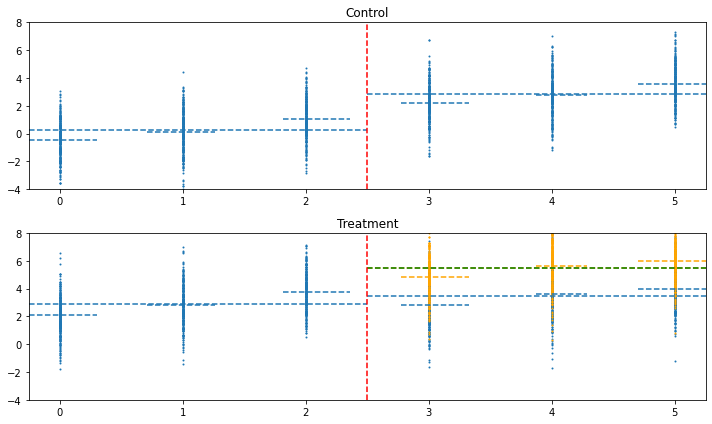

In [6]:
plot_data(data_1)

Control before mean 0.506
Control after mean 2.519
Treament before mean 2.588
Treament after mean 2.009
Treatment counterfactual after mean 4.009
control t_0 mean -0.442
control t_1 mean 0.087
control t_2 mean 1.872
control t_3 mean 0.769
control t_4 mean 1.415
control t_5 mean 5.374
treatment t_0 mean 2.117
treatment t_1 mean 2.180
treatment t_2 mean 3.466
treatment t_3 mean 0.372
treatment t_4 mean 0.865
treatment t_5 mean 4.791
treatment_cf t_0 mean 2.117
treatment_cf t_1 mean 2.180
treatment_cf t_2 mean 3.466
treatment_cf t_3 mean 2.372
treatment_cf t_4 mean 2.865
treatment_cf t_5 mean 6.791
Treatment estimated counterfactual after mean 4.601
Simple did-estimate -2.592


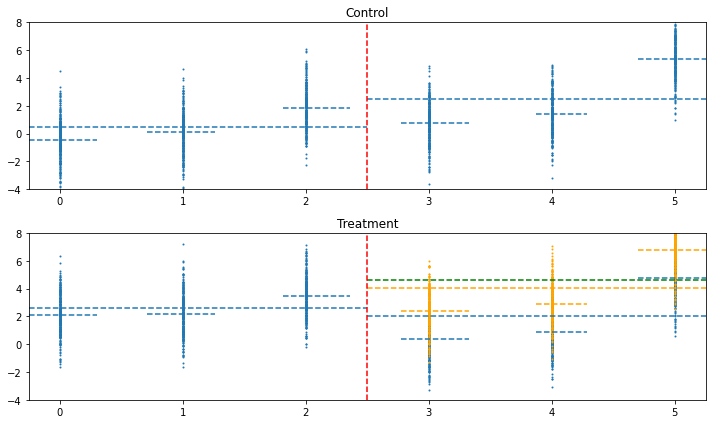

In [7]:
plot_data(data_2)

## Regression frame

In [8]:
def prepare_regression_frame(treatment, control):
    
    df = treatment.copy().append(control.copy(), ignore_index=True)
    df["time_group"] = df["time_group"].map({"before": 0, "after": 1})
    df["tc_group"] = df["tc_group"].map({"control": 0, "treatment": 1})
    df["tc_groupxtime_group"] = df["time_group"] * df["tc_group"]
    df["t"] = df["t"].astype(str)
    
    return df

df_1 = prepare_regression_frame(data_1["treatment"], data_1["control"])
df_2 = prepare_regression_frame(data_2["treatment"], data_2["control"])

## Simple DID regression

When *TGC* is zero, naive DiD-estimate of the treatment effect is correct (unbiased). 

In [9]:
reg_str = "var1 ~ 1 + tc_group + time_group + tc_groupxtime_group"
res = smf.ols(reg_str, data=df_1).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var1   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     771.5
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:14:07   Log-Likelihood:                -6695.1
No. Observations:                3600   AIC:                         1.340e+04
Df Residuals:                    3596   BIC:                         1.342e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2517      0.052      4.856      0.000       0.150       0.353
tc_group                2.6343      0.073     35.941      0.000       2.491       2.778
time_group              2.5952      0.073     35.407      0.000       2.451       2.739
tc_groupxtime_group    -1.9995      0.104    -19.290      0.000      -2.203      -1.796
==============================================================================
Omnibus:                        0.585   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.548
Skew:                          -0.028   Prob(JB):                        0.760
Kurtosis:                       3.022   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When *TGC* is not zero, naive DiD-estimate of the treatment effect is biased. 

In [10]:
reg_str = "var1 ~ 1 + tc_group + time_group + tc_groupxtime_group"
res = smf.ols(reg_str, data=df_2).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var1   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     189.3
Date:                Fri, 25 Mar 2022   Prob (F-statistic):          5.61e-114
Time:                        19:14:07   Log-Likelihood:                -7796.3
No. Observations:                3600   AIC:                         1.560e+04
Df Residuals:                    3596   BIC:                         1.563e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5056      0.070      7.184      0.000       0.368       0.644
tc_group                2.0823      0.100     20.922      0.000       1.887       2.277
time_group              2.0135      0.100     20.231      0.000       1.818       2.209
tc_groupxtime_group    -2.5923      0.141    -18.418      0.000      -2.868      -2.316
==============================================================================
Omnibus:                       72.669   Durbin-Watson:                   0.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.176
Skew:                           0.321   Prob(JB):                     2.12e-16
Kurtosis:                       2.735   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## DID regression with *TGC* as covariate

When we can adjust for *TGC*, the DiD-estimate is estimated with less bias (seems there is some bias left?).

In [11]:
reg_str = "var1 ~ 1 + TGC + tc_group + time_group + tc_groupxtime_group"
res = smf.ols(reg_str, data=df_2).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var1   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     527.5
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:14:07   Log-Likelihood:                -7229.1
No. Observations:                3600   AIC:                         1.447e+04
Df Residuals:                    3595   BIC:                         1.450e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1241      0.061      2.033      0.042       0.004       0.244
TGC                     1.0553      0.029     36.493      0.000       0.999       1.112
tc_group                2.4317      0.086     28.419      0.000       2.264       2.599
time_group              1.3305      0.087     15.282      0.000       1.160       1.501
tc_groupxtime_group    -1.9018      0.122    -15.624      0.000      -2.140      -1.663
==============================================================================
Omnibus:                      121.330   Durbin-Watson:                   0.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.868
Skew:                           0.461   Prob(JB):                     2.32e-29
Kurtosis:                       2.832   Cond. No.                         7.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## DID regression with time fixed effects

Here treatment is a one-off phenomenon between periods 2 and 3. In addition to *time_grop*, it makes no sense (in identification sense!) to add time fixed effects for each time period: it adds nothing new compared to having *time_group* in the regression. If treatment was staggered over multiple periods, then we could need time FEs. See e.g. [here](https://stats.stackexchange.com/questions/455986/panel-data-diff-in-diff-and-the-pattern-of-the-binary-treatment-indicator).

In [12]:
reg_str = "var1 ~ -1 + tc_group + t + tc_groupxtime_group"
res = smf.ols(reg_str, data=df_1).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   var1   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     477.8
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:14:07   Log-Likelihood:                -6404.9
No. Observations:                3600   AIC:                         1.283e+04
Df Residuals:                    3592   BIC:                         1.288e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
t[0]                   -0.5220      0.068     -7.715      0.000      -0.655      -0.389
t[1]                    0.1724      0.068      2.548      0.011       0.040       0.305
t[2]                    1.1046      0.068     16.326      0.000       0.972       1.237
t[3]                    2.1919      0.068     32.398      0.000       2.059       2.325
t[4]                    2.8729      0.068     42.463      0.000       2.740       3.006
t[5]                    3.4757      0.068     51.372      0.000       3.343       3.608
tc_group                2.6343      0.068     38.936      0.000       2.502       2.767
tc_groupxtime_group    -1.9995      0.096    -20.897      0.000      -2.187      -1.812
==============================================================================
Omnibus:                        1.671   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.606
Skew:                          -0.040   Prob(JB):                        0.448
Kurtosis:                       3.065   Cond. No.                         4.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""